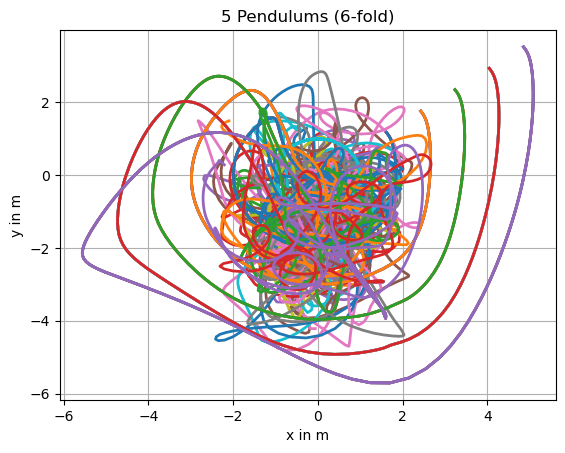


Time for simulation: 32.169840574264526 seconds
Time for plotting: 0.15789031982421875 seconds
Time for animation calculation: 0.06116223335266113 seconds

Time overall: 32.388893127441406 seconds

Angle used was: 0.35



In [9]:

# Code for multiple n-fold Pendulums; Kanes Method is used here

# ------------------------------------------------------------------------------------------------------------------------ #

# import all necessary packages
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import time
import matplotlib
import random as rd

from sympy import symbols
from sympy.physics import mechanics

from sympy import Dummy, lambdify
from scipy.integrate import odeint

from matplotlib import animation

from IPython.display import HTML

# ------------------------------------------------------------------------------------------------------------------------ #

def integrate_pendulum_multiple(n, times, initial_positions, initial_velocities, lengths, masses):
    """
    Uses the Kane Methode to solve the equations of motion for a pendulum with n segments
    Define number of segments, simulation time, initial angles and angular velocities aswell as masses and lengths of each segment
    Specific steps are highlightes below with comments in code itself

    Args:
        n (int): number of segments of pendulum
        times (numpy array): numpy array of simulation time; defined over start and end time and number of steps
        initial_positions (list): list of initial angles of every pendulum segment
        initial_velocities (list): list of initial angular velocities of every pendulum segment
        lengths (list): list of lengths of every pendulum segment
        masses (list): list of masses of every pendulum segment

    Returns:
        p (): points p
    """
    #-------------------------------------------------
    # Step 1: construct the pendulum model
    
    # Generalized coordinates and velocities
    # (in this case, angular positions & velocities of each mass) 
    q = mechanics.dynamicsymbols('q:{0}'.format(n))
    u = mechanics.dynamicsymbols('u:{0}'.format(n))

    # mass and length
    m = symbols('m:{0}'.format(n))
    l = symbols('l:{0}'.format(n))

    # gravity and time symbols
    g, t = symbols('g,t')
    
    #--------------------------------------------------
    # Step 2: build the model using Kane's Method

    # Create pivot point reference frame
    A = mechanics.ReferenceFrame('A')
    P = mechanics.Point('P')
    P.set_vel(A, 0)

    # lists to hold particles, forces, and kinetic ODEs
    # for each pendulum in the chain
    particles = []
    forces = []
    kinetic_odes = []

    for i in range(n):
        # Create a reference frame following the i^th mass
        Ai = A.orientnew('A' + str(i), 'Axis', [q[i], A.z])
        Ai.set_ang_vel(A, u[i] * A.z)

        # Create a point in this reference frame
        Pi = P.locatenew('P' + str(i), l[i] * Ai.x)
        Pi.v2pt_theory(P, A, Ai)

        # Create a new particle of mass m[i] at this point
        Pai = mechanics.Particle('Pa' + str(i), Pi, m[i])
        particles.append(Pai)

        # Set forces & compute kinematic ODE
        forces.append((Pi, m[i] * g * A.x))
        kinetic_odes.append(q[i].diff(t) - u[i])

        P = Pi

    # Generate equations of motion
    KM = mechanics.KanesMethod(A, q_ind=q, u_ind=u, kd_eqs=kinetic_odes)
    fr, fr_star = KM.kanes_equations(particles, forces)
    
    #-----------------------------------------------------
    # Step 3: numerically evaluate equations and integrate

    # initial positions and velocities – assumed to be given in degrees
    y0 = np.deg2rad(np.concatenate([np.broadcast_to(initial_positions, n), np.broadcast_to(initial_velocities, n)]))
        
    # lengths and masses
    lengths = np.broadcast_to(lengths, n)
    masses = np.broadcast_to(masses, n)

    # Fixed parameters: gravitational constant, lengths, and masses
    parameters = [g] + list(l) + list(m)
    parameter_vals = [9.81] + list(lengths) + list(masses)

    # define symbols for unknown parameters
    unknowns = [Dummy() for i in q + u]
    unknown_dict = dict(zip(q + u, unknowns))
    kds = KM.kindiffdict()

    # substitute unknown symbols for qdot terms
    mm_sym = KM.mass_matrix_full.subs(kds).subs(unknown_dict)
    fo_sym = KM.forcing_full.subs(kds).subs(unknown_dict)

    # create functions for numerical calculation 
    mm_func = lambdify(unknowns + parameters, mm_sym)
    fo_func = lambdify(unknowns + parameters, fo_sym)

    # function which computes the derivatives of parameters
    def gradient(y, t, args):
        vals = np.concatenate((y, args))
        sol = np.linalg.solve(mm_func(*vals), fo_func(*vals))
        return np.array(sol).T[0]

    # ODE integration
    return odeint(gradient, y0, times, args=(parameter_vals,))

def get_xy_coords(p, lengths):
    """
    Get x and y coordinates from lengths of pendulums and p

    Args:
        p (): points p
        lengths (list): list of lengths of each pendulum

    Returns:
        x (): numpy cumsum with all x values
        y (): numpy cumsum with all y values
    """
    # calculate x and y coordinates from lengths and points; safe values in x and y array for animation
    p = np.atleast_2d(p)
    n = p.shape[1] // 2
    lengths_neg = [ -x for x in lengths]
    zeros = np.zeros(p.shape[0])[:, None]
    x = np.hstack([zeros, lengths * np.sin(p[:, :n])])
    y = np.hstack([zeros, lengths_neg * np.cos(p[:, :n])])
    return np.cumsum(x, 1), np.cumsum(y, 1)

def animate_pendulum_multiple(x, y):
    """
    Animates pendulum motion over x and y values; the figure and axes object are defined; creation of lines object;
    definition of init and animate function
    Animate function: for each frame i every line in lines is updated with values for every pendulum forthis specific index i

    Args:
        x (List): list of all x values for every pendulum
        y (list): list of all y values for every pendulum

    Returns:
        anim (): animation object
    """
    # define plot and ax; set some parameters
    title = 'Pendel motion over time (' + str(n_pendulums) + " Pendulums, " + str(n) + "-fold)"
    fig = plt.figure()
    ax = fig.add_subplot(aspect='equal')
    ax.set_xlim(-1.05*sum_length, 1.05*sum_length)
    ax.set_ylim(-1.05*sum_length, 1.05*sum_length)
    ax.set_title(title)
    ax.set_xlabel('x in m')
    ax.set_ylabel('y in m')
    ax.grid(1)

    # initiate the lines object here; lines object contains n_pendulums as line objects
    lines = [plt.plot([], [], 'o-', lw=2)[0] for _ in range(n_pendulums)]

    # initialize the lines object; iterate over every line
    def init():
        for line in lines:
            line.set_data([], [])
        return lines

    # animate the position of each line for every frame i; iterate over every line
    def animate(i):
        for j,line in enumerate(lines):
            x = x_array[j]
            y = y_array[j]
            line.set_data(x[i], y[i])
        return lines

    # create animation
    anim = animation.FuncAnimation(fig, animate, frames=len(times), interval=1000 * times.max() / len(times), blit=True, init_func=init)

    # closes the static plot which is not used here
    plt.close(fig)
    
    return anim

# ------------------------------------------------------------------------------------------------------------------------ #

# number n of segments per pendulum
n=6

# number of pendulums
n_pendulums = 5

# error between each starting position; is added e-times to random start angle with e being the index in for loop which iterates over n_pendulums
error = 1E-6

# time vector for simulation and animation; number of samples should not be changed to ensure real-time behaviour of animation and saved gif
# 50 fps chosen as gif could not be displayed with higher values and an increase would not be noticable for humans anyway
t_start = 0
t_end = 10
times = np.linspace(t_start, t_end, (t_end-t_start)*50)

# either predefine rand_angles with desired values in rad or use rd.random() function; comment lines out respectively
#rand_angles = rd.random()
rand_angles = 0.35

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

time_1 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# predefine empty lists
x_array = []
y_array = []

for e in range(n_pendulums):

    # predefine empty lists and parameters
    angles = []
    velocities = []
    lengths = []
    masses = []
    sum_length = 0

    # use the same random start angle for each pendulum and each pendulum segment; same for mass and length; fixed at 1m and 1kg
    # use of fixed values here for simplification of animation; with all variables random it could look to chaotic
    # do display the chaotic nature of the system the little error defined above is enough
    for i in range(n):
        angles.append((rand_angles+e*error)*360)
        velocities.append(0)
        lengths.append(1)
        masses.append(1)
        sum_length = sum_length + 1

    # integrate pendulum and create p
    p = integrate_pendulum_multiple(n, times, angles, velocities, lengths, masses)

    # get x and y coordinates from p and lengths
    x, y = get_xy_coords(p, lengths)

    # append calculated x and y for each pendulum (n_pendulums times) to lists
    x_array.append(x)
    y_array.append(y)

time_2 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# create title for plot
title = str(n_pendulums) + ' Pendulums (' + str(n) + '-fold)'

# plot each pair of x and y coordinates
for i in range(n_pendulums):
    plt.plot(x_array[i], y_array[i], lw=2)
   
plt.title(title)
plt.xlabel('x in m')
plt.ylabel('y in m')
plt.grid()
plt.show()

time_3 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# set data limit of animation; in MB; might need to be enlarged for other applications
matplotlib.rcParams['animation.embed_limit'] = 100.0

# create animation
anim = animate_pendulum_multiple(x_array, y_array)

time_4 = time.time()

# ------------------------------------------------------------------------------------------------------------------------ #

# evaluation of times; not necessary for function
times_simulation = time_2 - time_1
times_plotting = time_3 - time_2
times_animation_calculation = time_4 - time_3

print("")
print("Time for simulation:", times_simulation, "seconds")
print("Time for plotting:", times_plotting, "seconds")
print("Time for animation calculation:", times_animation_calculation, "seconds")
print("")
print("Time overall:", time_4 - time_1, "seconds")
print("")
print("Angle used was:", rand_angles)
print("")


In [10]:

# execute/open animation with this line
#HTML(anim.to_jshtml())

# create name for give in dependence of n
name_gif = "Multiple_" + str(n) + "-fold_Pendulum.gif"

# save animation as gif to document results; dpi could be varied; do not change fps value: otherwise no real time behaviour!
from matplotlib.animation import FuncAnimation, PillowWriter
anim.save(name_gif, dpi=300, writer=PillowWriter(fps=50))
